# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

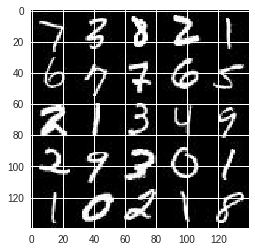

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

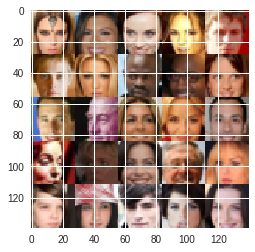

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_ real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out

    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    input_real, input_z, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 8.8698... Generator Loss: 0.0002
Epoch 1/2... Discriminator Loss: 0.2094... Generator Loss: 1.9083
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 4.6718
Epoch 1/2... Discriminator Loss: 0.1083... Generator Loss: 3.8079
Epoch 1/2... Discriminator Loss: 0.1491... Generator Loss: 2.3525
Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 2.1720
Epoch 1/2... Discriminator Loss: 0.3216... Generator Loss: 2.8176
Epoch 1/2... Discriminator Loss: 0.2086... Generator Loss: 2.1887
Epoch 1/2... Discriminator Loss: 1.8243... Generator Loss: 7.1491
Epoch 1/2... Discriminator Loss: 0.1162... Generator Loss: 6.4618


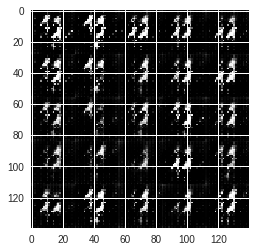

Epoch 1/2... Discriminator Loss: 0.5998... Generator Loss: 6.1901
Epoch 1/2... Discriminator Loss: 0.2645... Generator Loss: 2.3561
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 3.0993
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 1.7376
Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 2.1385
Epoch 1/2... Discriminator Loss: 0.5435... Generator Loss: 4.5290
Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 6.3957
Epoch 1/2... Discriminator Loss: 0.7067... Generator Loss: 1.4819
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 1.9959
Epoch 1/2... Discriminator Loss: 1.6040... Generator Loss: 0.4121


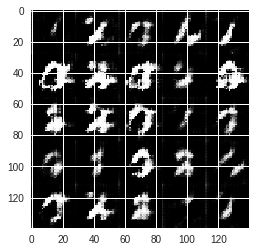

Epoch 1/2... Discriminator Loss: 0.9041... Generator Loss: 0.9807
Epoch 1/2... Discriminator Loss: 0.3575... Generator Loss: 3.4700
Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 1.9286
Epoch 1/2... Discriminator Loss: 1.8710... Generator Loss: 4.5319
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 0.7785... Generator Loss: 2.4997
Epoch 1/2... Discriminator Loss: 0.2749... Generator Loss: 2.8089
Epoch 1/2... Discriminator Loss: 1.1865... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.0359
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 1.7381


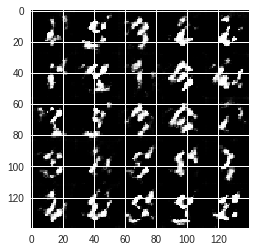

Epoch 1/2... Discriminator Loss: 0.6513... Generator Loss: 1.2609
Epoch 1/2... Discriminator Loss: 0.7168... Generator Loss: 1.9640
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.8079
Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 1.8694
Epoch 1/2... Discriminator Loss: 0.3780... Generator Loss: 2.1301
Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 1.3429
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 0.4126... Generator Loss: 3.1208
Epoch 1/2... Discriminator Loss: 1.6551... Generator Loss: 0.4642
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 0.8044


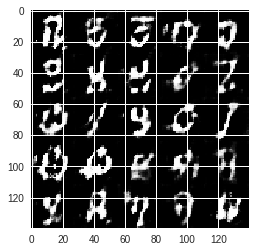

Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 1.1421... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.5438
Epoch 1/2... Discriminator Loss: 0.6925... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 2.2792
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 1.4123
Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 1.4260
Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 2.6861
Epoch 1/2... Discriminator Loss: 0.7836... Generator Loss: 1.3055


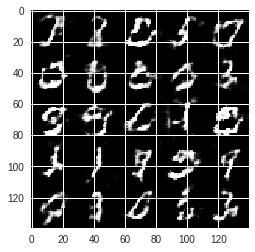

Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 1.6880
Epoch 1/2... Discriminator Loss: 1.9051... Generator Loss: 0.2607
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 2.3002
Epoch 1/2... Discriminator Loss: 0.7580... Generator Loss: 1.1007
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 0.7464... Generator Loss: 1.4045
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.3731


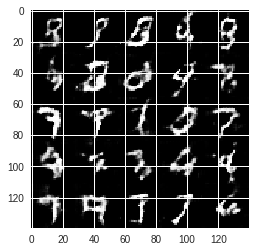

Epoch 1/2... Discriminator Loss: 0.7359... Generator Loss: 2.9074
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 1.5241
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 1.8716
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 2.5103
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 0.7969... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 2.1892
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.9183... Generator Loss: 0.2116


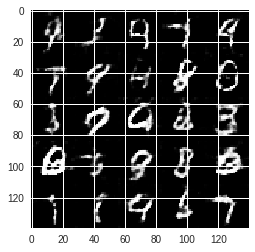

Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 1.2491
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 1.3894
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 1.0592... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 2.0171
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.4697
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.2768
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.4417


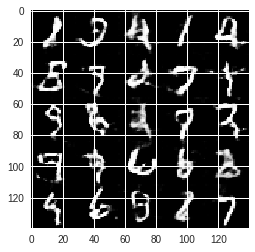

Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 2.0535
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.2992
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.6055
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 2.1584
Epoch 1/2... Discriminator Loss: 1.6827... Generator Loss: 0.2939
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.3457
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.5251


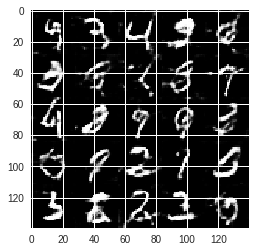

Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.4153
Epoch 1/2... Discriminator Loss: 1.8222... Generator Loss: 0.2425
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 2.0074
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.6247
Epoch 2/2... Discriminator Loss: 1.3278... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.2192... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.4639
Epoch 2/2... Discriminator Loss: 0.8650... Generator Loss: 0.9494
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 2.7466


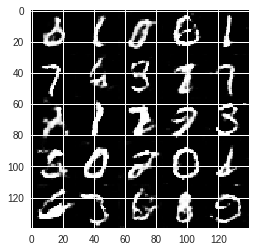

Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.4953
Epoch 2/2... Discriminator Loss: 1.3154... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 1.3077
Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.6753... Generator Loss: 0.3324
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.0708


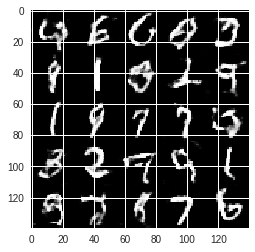

Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.5618
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 1.9819
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.1558
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.9054
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 1.6629... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 0.8021... Generator Loss: 1.2483
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 0.6625


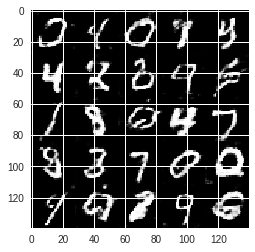

Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.6763
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 1.2978
Epoch 2/2... Discriminator Loss: 1.6645... Generator Loss: 3.0275
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 2.2075... Generator Loss: 0.1838
Epoch 2/2... Discriminator Loss: 1.4696... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 0.8726
Epoch 2/2... Discriminator Loss: 1.4688... Generator Loss: 0.4029
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.7274
Epoch 2/2... Discriminator Loss: 1.7330... Generator Loss: 0.2976


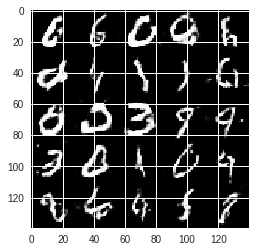

Epoch 2/2... Discriminator Loss: 0.9329... Generator Loss: 1.4688
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.1663
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 0.6968
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 0.8963
Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.8092
Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 2.3597
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.4713


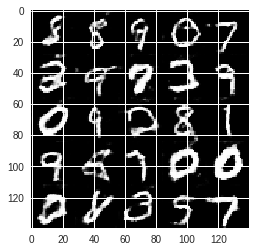

Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.4726
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 1.6705... Generator Loss: 0.3310
Epoch 2/2... Discriminator Loss: 0.4030... Generator Loss: 1.6175
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.4114
Epoch 2/2... Discriminator Loss: 1.7797... Generator Loss: 0.3000
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.2601
Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.4000


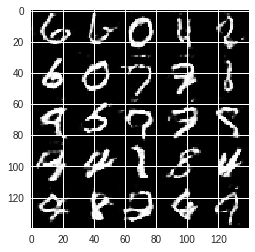

Epoch 2/2... Discriminator Loss: 0.9760... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.2764
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 1.6804... Generator Loss: 0.3181
Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 0.3668... Generator Loss: 2.1621
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.4956
Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 1.3716
Epoch 2/2... Discriminator Loss: 2.4666... Generator Loss: 0.1437
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 1.1467


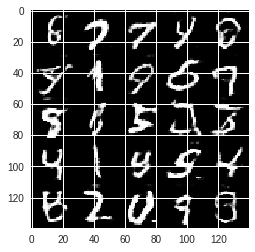

Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 1.4954
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 3.4964
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 0.4078
Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 1.9967... Generator Loss: 0.2867
Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 0.6650
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 0.9869
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.5481
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.1090


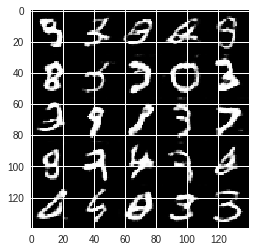

Epoch 2/2... Discriminator Loss: 1.5154... Generator Loss: 0.3762
Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 1.1369... Generator Loss: 3.0292
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 2.7485
Epoch 2/2... Discriminator Loss: 1.9954... Generator Loss: 0.2528
Epoch 2/2... Discriminator Loss: 0.5838... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.4669
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 0.7023


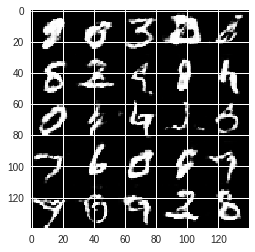

Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 3.2323
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 0.7672
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 1.5601
Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 0.3950
Epoch 2/2... Discriminator Loss: 2.3635... Generator Loss: 0.1756


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6136... Generator Loss: 0.0784
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 2.2657
Epoch 1/1... Discriminator Loss: 0.2736... Generator Loss: 5.5766
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 2.5474
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 5.0615
Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 3.7701
Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 2.1945
Epoch 1/1... Discriminator Loss: 2.5759... Generator Loss: 0.1284
Epoch 1/1... Discriminator Loss: 1.8125... Generator Loss: 6.6672


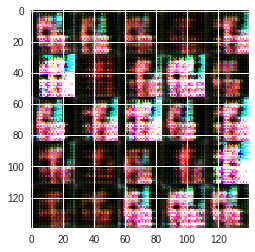

Epoch 1/1... Discriminator Loss: 1.7519... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 0.2276... Generator Loss: 2.1168
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 5.1434
Epoch 1/1... Discriminator Loss: 1.6174... Generator Loss: 2.1450
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 3.0394
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 3.1680
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.6294


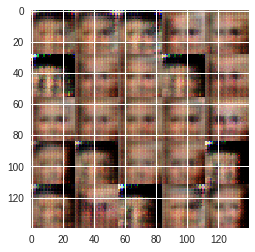

Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 2.8373
Epoch 1/1... Discriminator Loss: 1.8270... Generator Loss: 0.2874
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.2414
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 2.0629
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 3.0355
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 4.2018
Epoch 1/1... Discriminator Loss: 0.2845... Generator Loss: 2.3522
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6101


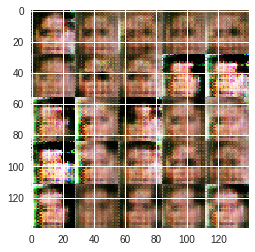

Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 2.4107
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.4224
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.8127... Generator Loss: 0.2968
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 2.3587... Generator Loss: 0.1525


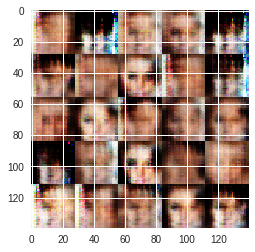

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.5479... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 1.4277


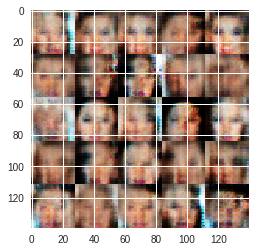

Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.7693
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.9644


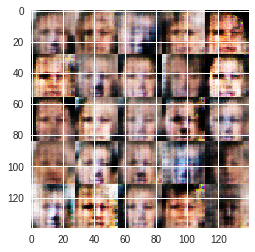

Epoch 1/1... Discriminator Loss: 3.3859... Generator Loss: 4.6082
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 2.3834


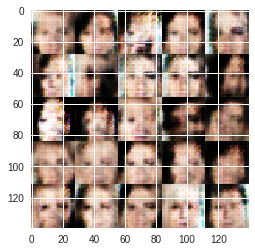

Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 2.1811... Generator Loss: 3.5190
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.5928
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.9887


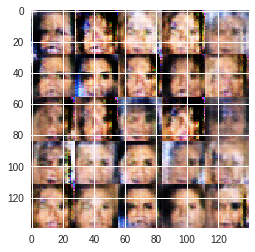

Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.3269
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 2.3461
Epoch 1/1... Discriminator Loss: 1.8184... Generator Loss: 0.3501
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.3882
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.4489


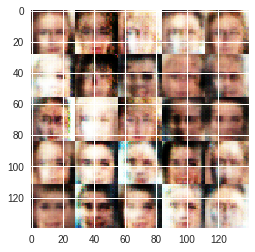

Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 0.5440... Generator Loss: 1.4597
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 2.1480
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.4576
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5351


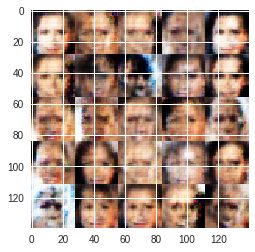

Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 2.0319
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.4283
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.8132
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.7285
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5432


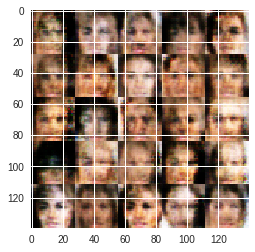

Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.7942
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 1.7291
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 2.5752
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 0.8824


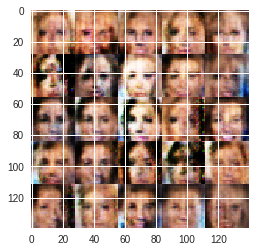

Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 2.6885
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.8645
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.5939
Epoch 1/1... Discriminator Loss: 1.8946... Generator Loss: 1.9267
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.7763


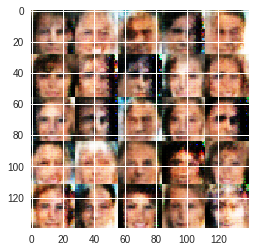

Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.4738


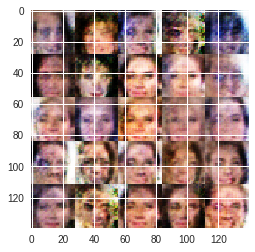

Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.5091
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.7801... Generator Loss: 0.3201
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.6844


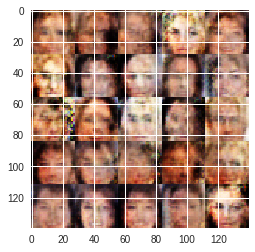

Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.7095
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.6168


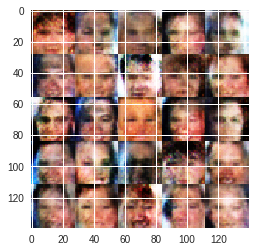

Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.9961
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 3.5069
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.2675


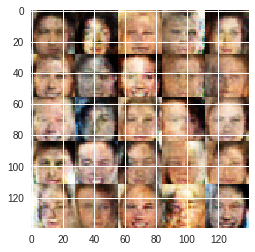

Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 2.1872
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.1748


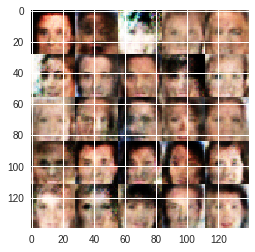

Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.3911


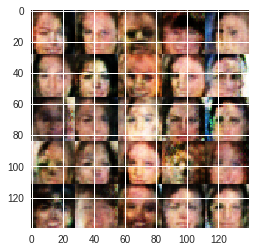

Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.5728
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.4538


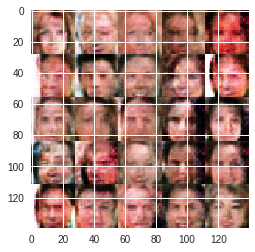

Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.5037
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.4973


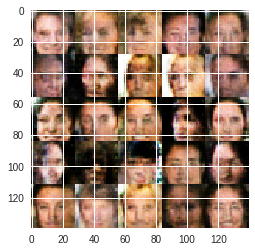

Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.6014
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 2.3022
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.7548


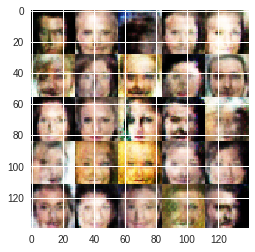

Epoch 1/1... Discriminator Loss: 1.7614... Generator Loss: 2.0158
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.7706


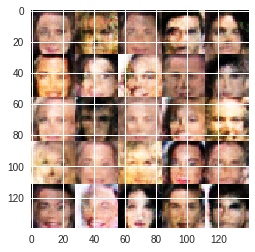

Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 0.7331... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.9116


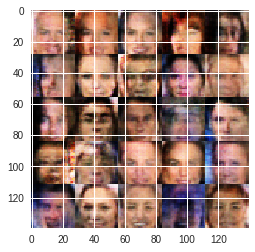

Epoch 1/1... Discriminator Loss: 1.9465... Generator Loss: 0.1982
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.8058


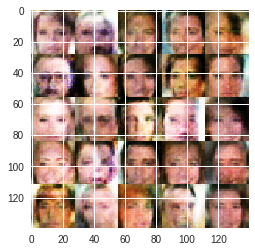

Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 2.3557


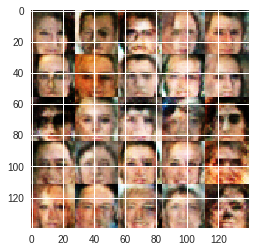

Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.3319
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.6862... Generator Loss: 0.3030


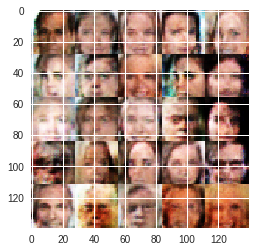

Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 1.3107
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.9234
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.4964


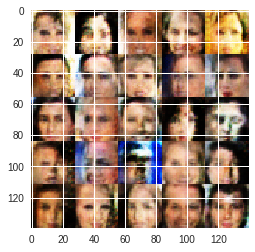

Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.4997
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.5764
Epoch 1/1... Discriminator Loss: 2.3943... Generator Loss: 0.1366
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 1.8764
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8052


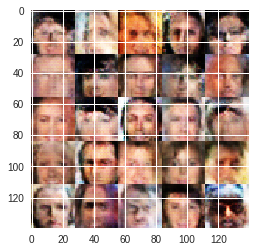

Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.2952


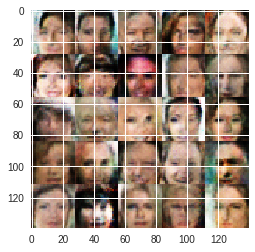

Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.2917


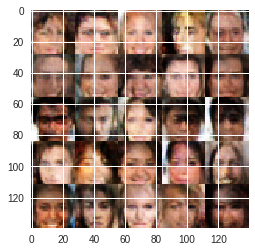

Epoch 1/1... Discriminator Loss: 1.6633... Generator Loss: 3.2345
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.2352


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.